# GAN For Fashion-MNIST Dataset

#Import Library

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from tensorflow.keras import layers

# Define Constants

In [2]:
# Define constants
noise_dim = 100
num_classes = 2
batch_size = 32
epochs = 10

# Load Data

In [3]:
def preprocess_data(x, y):
    idx = np.isin(y, [4, 5])
    x = (x[idx].astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
    x = x.reshape(-1, 28, 28, 1)  # Reshape
    y = (y[idx] == 5).astype(np.int32)  # Map labels to 0 and 1
    return x, y

def load_data():
    fashion_mnist = tf.keras.datasets.fashion_mnist
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

    x_train, y_train = preprocess_data(x_train, y_train)
    x_test, y_test = preprocess_data(x_test, y_test)

    return x_train, y_train, x_test, y_test

In [4]:
# Load data
x_train, y_train, x_test, y_test = load_data()

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(12000, 28, 28, 1)
(12000,)
(2000, 28, 28, 1)
(2000,)


# a. Baseline Model, Train, and Evaluate

In [5]:
class GAN:
    def __init__(self, noise_dim, num_classes):
        self.noise_dim = noise_dim
        self.num_classes = num_classes
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.compile_models()

    def build_generator(self):
        noise_input = tf.keras.Input(shape=(self.noise_dim,), name="Noise_Input")
        label_input = tf.keras.Input(shape=(self.num_classes,), name="Label_Input")

        x = layers.Concatenate()([noise_input, label_input])
        x = layers.Dense(128)(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dense(256)(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dense(512)(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dense(1024)(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dense(28 * 28, activation='tanh')(x)
        img_output = layers.Reshape((28, 28, 1))(x)

        return tf.keras.Model([noise_input, label_input], img_output, name="Generator")

    def build_discriminator(self):
        img_input = tf.keras.Input(shape=(28, 28, 1), name="Image_Input")
        label_input = tf.keras.Input(shape=(self.num_classes,), name="Label_Input")

        x = layers.Flatten()(img_input)
        x = layers.Concatenate()([x, label_input])
        x = layers.Dense(512)(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dense(1024)(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dense(1024)(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dense(512)(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        validity = layers.Dense(1)(x)

        return tf.keras.Model([img_input, label_input], validity, name="Discriminator")

    def compile_models(self):
        self.generator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                               loss='binary_crossentropy')
        self.discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                                   loss='binary_crossentropy', metrics=['accuracy'])

    def generator_forward(self, noise, labels):
        labels_onehot = tf.cast(tf.one_hot(labels, depth=self.num_classes), tf.float32)
        return self.generator([noise, labels_onehot])

    def discriminator_forward(self, images, labels):
        labels_onehot = tf.cast(tf.one_hot(labels, depth=self.num_classes), tf.float32)
        images = tf.convert_to_tensor(images, dtype=tf.float32)
        return self.discriminator([images, labels_onehot])

# Instantiate GAN
gan = GAN(noise_dim=noise_dim, num_classes=num_classes)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [6]:
gan.generator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Noise_Input (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Label_Input (InputLayer)  │ (None, 2)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 102)            │              0 │ Noise_Input[0][0],     │
│                           │                        │                │ Label_Input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         13,184 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         33,024 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │        131,584 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 512)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1024)           │        525,312 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 1024)           │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 784)            │        803,600 │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 28, 28, 1)      │              0 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,506,704 (5.75 MB)

 Trainable params: 1,506,704 (5.75 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
gan.discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Image_Input (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 784)            │              0 │ Image_Input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Label_Input (InputLayer)  │ (None, 2)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 786)            │              0 │ flatten[0][0],         │
│ (Concatenate)             │                        │                │ Label_Input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 512)            │        402,944 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 512)            │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1024)           │        525,312 │ leaky_re_lu_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_5 (LeakyReLU) │ (None, 1024)           │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1024)           │      1,049,600 │ leaky_re_lu_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_6 (LeakyReLU) │ (None, 1024)           │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 512)            │        524,800 │ leaky_re_lu_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_7 (LeakyReLU) │ (None, 512)            │              0 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 1)              │            513 │ leaky_re_lu_7[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,503,169 (9.55 MB)

 Trainable params: 2,503,169 (9.55 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Epoch 1/10
Generator Loss: 2.619765281677246, Discriminator Loss: 0.29461753368377686
Epoch 2/10
Generator Loss: 1.3337528705596924, Discriminator Loss: 0.49905723333358765
Epoch 3/10
Generator Loss: 2.8256776332855225, Discriminator Loss: 0.9126061201095581
Epoch 4/10
Generator Loss: 0.8270158767700195, Discriminator Loss: 1.682149052619934
Epoch 5/10
Generator Loss: 1.663656234741211, Discriminator Loss: 0.7424244284629822


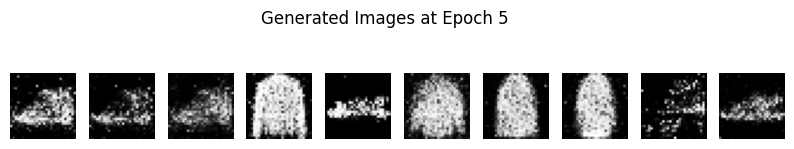

Epoch 6/10
Generator Loss: 1.7815277576446533, Discriminator Loss: 0.8757161498069763
Epoch 7/10
Generator Loss: 2.074518918991089, Discriminator Loss: 0.5112718343734741
Epoch 8/10
Generator Loss: 1.469602346420288, Discriminator Loss: 1.1000174283981323
Epoch 9/10
Generator Loss: 1.4717566967010498, Discriminator Loss: 0.665734052658081
Epoch 10/10
Generator Loss: 1.5816454887390137, Discriminator Loss: 1.0823442935943604


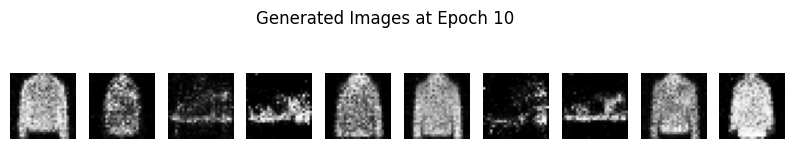

In [9]:
# Train the GAN
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for batch in range(len(x_train) // batch_size):
        idx = np.random.randint(0, len(x_train), batch_size)
        batch_images = x_train[idx]
        batch_labels = y_train[idx]

        noise = tf.random.normal([batch_size, noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = gan.generator_forward(noise, batch_labels)

            real_output = gan.discriminator_forward(batch_images, batch_labels)
            fake_output = gan.discriminator_forward(generated_images, batch_labels)

            gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
            disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, gan.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, gan.discriminator.trainable_variables)

        gan.generator.optimizer.apply_gradients(zip(gradients_of_generator, gan.generator.trainable_variables))
        gan.discriminator.optimizer.apply_gradients(zip(gradients_of_discriminator, gan.discriminator.trainable_variables))

    print(f"Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}")

    # Plot generated images every 5 epochs
    if (epoch + 1) % 5 == 0:
        noise = tf.random.normal([10, noise_dim])
        labels = np.random.randint(0, num_classes, 10)
        generated_images = gan.generator_forward(noise, labels)
        generated_images = (generated_images + 1) / 2.0  # Rescale to [0, 1]

        plt.figure(figsize=(10, 2))
        for i in range(10):
            plt.subplot(1, 10, i + 1)
            plt.imshow(generated_images[i, :, :, 0], cmap='gray')
            plt.axis('off')
        plt.suptitle(f"Generated Images at Epoch {epoch + 1}")
        plt.show()

In [17]:
# Fréchet Inception Distance
def evaluate(generator, real_images, labels, noise_dim):
    noise = tf.random.normal(shape=(len(real_images), noise_dim))
    generated_imgs = generator([noise, tf.one_hot(labels, depth=num_classes)])
    generated_imgs = generated_imgs.numpy().reshape(generated_imgs.shape[0], -1)
    real_imgs = real_images.reshape(real_images.shape[0], -1)

    mu1, sigma1 = np.mean(real_imgs, axis=0), np.cov(real_imgs, rowvar=False)
    mu2, sigma2 = np.mean(generated_imgs, axis=0), np.cov(generated_imgs, rowvar=False)

    diff = mu1 - mu2
    covmean, _ = sqrtm(sigma1 @ sigma2, disp=False)
    covmean = covmean.real if np.iscomplexobj(covmean) else covmean

    fid_score = diff @ diff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid_score

fid_score = evaluate(gan.generator, x_test, y_test, noise_dim)
print("FID Score", fid_score)

FID Score 83.08958479687834


# b. Modified Discriminator, Train, and Evaluate

In [11]:
class ModifiedGAN:
    def __init__(self, noise_dim, num_classes):
        self.noise_dim = noise_dim
        self.num_classes = num_classes
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.compile_models()

    def build_generator(self):
        noise_input = tf.keras.Input(shape=(self.noise_dim,), name="Noise_Input")
        label_input = tf.keras.Input(shape=(self.num_classes,), name="Label_Input")

        x = layers.Concatenate()([noise_input, label_input])
        x = layers.Dense(128)(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dense(256)(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dense(512)(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dense(1024)(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dense(28 * 28, activation='tanh')(x)
        img_output = layers.Reshape((28, 28, 1))(x)

        return tf.keras.Model([noise_input, label_input], img_output, name="Generator")

    def build_discriminator(self):
        img_input = tf.keras.Input(shape=(28, 28, 1), name="Image_Input")
        label_input = tf.keras.Input(shape=(self.num_classes,), name="Label_Input")

        x = layers.Flatten()(img_input)
        x = layers.Concatenate()([x, label_input])
        x = layers.Dense(512)(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dense(1024)(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dense(768)(x)
        x = layers.ReLU()(x)
        x = layers.Dense(256)(x)
        x = layers.ReLU()(x)
        validity = layers.Dense(1)(x)

        return tf.keras.Model([img_input, label_input], validity, name="Discriminator")

    def compile_models(self):
        self.generator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                               loss='binary_crossentropy')
        self.discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                                   loss='binary_crossentropy', metrics=['accuracy'])

    def generator_forward(self, noise, labels):
        labels_onehot = tf.cast(tf.one_hot(labels, depth=self.num_classes), tf.float32)
        return self.generator([noise, labels_onehot])

    def discriminator_forward(self, images, labels):
        labels_onehot = tf.cast(tf.one_hot(labels, depth=self.num_classes), tf.float32)
        images = tf.convert_to_tensor(images, dtype=tf.float32)
        return self.discriminator([images, labels_onehot])

# Instantiate Modified-GAN
modified_gan = ModifiedGAN(noise_dim=noise_dim, num_classes=num_classes)

In [12]:
modified_gan.generator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Noise_Input (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Label_Input (InputLayer)  │ (None, 2)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 102)            │              0 │ Noise_Input[0][0],     │
│ (Concatenate)             │                        │                │ Label_Input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 128)            │         13,184 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_8 (LeakyReLU) │ (None, 128)            │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 256)            │         33,024 │ leaky_re_lu_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_9 (LeakyReLU) │ (None, 256)            │              0 │ dense_11[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 512)            │        131,584 │ leaky_re_lu_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_10            │ (None, 512)            │              0 │ dense_12[0][0]         │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 1024)           │        525,312 │ leaky_re_lu_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_11            │ (None, 1024)           │              0 │ dense_13[0][0]         │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 784)            │        803,600 │ leaky_re_lu_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 28, 28, 1)      │              0 │ dense_14[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,506,704 (5.75 MB)

 Trainable params: 1,506,704 (5.75 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
modified_gan.discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Image_Input (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 784)            │              0 │ Image_Input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Label_Input (InputLayer)  │ (None, 2)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 786)            │              0 │ flatten_1[0][0],       │
│ (Concatenate)             │                        │                │ Label_Input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 512)            │        402,944 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_12            │ (None, 512)            │              0 │ dense_15[0][0]         │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 1024)           │        525,312 │ leaky_re_lu_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_13            │ (None, 1024)           │              0 │ dense_16[0][0]         │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 768)            │        787,200 │ leaky_re_lu_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 768)            │              0 │ dense_17[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 256)            │        196,864 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 256)            │              0 │ dense_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 1)              │            257 │ re_lu_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,912,577 (7.30 MB)

 Trainable params: 1,912,577 (7.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
Generator Loss: 2.8470380306243896, Discriminator Loss: 0.7979081273078918
Epoch 2/10
Generator Loss: 0.8038747906684875, Discriminator Loss: 1.022367000579834
Epoch 3/10
Generator Loss: 1.707176685333252, Discriminator Loss: 0.5425106883049011
Epoch 4/10
Generator Loss: 1.1546142101287842, Discriminator Loss: 0.6969044208526611
Epoch 5/10
Generator Loss: 1.1675877571105957, Discriminator Loss: 1.0581541061401367


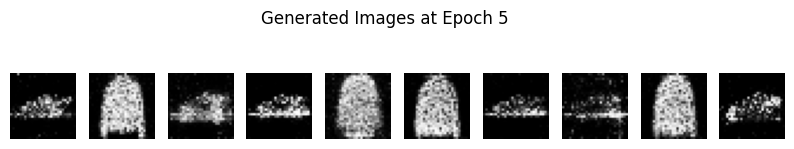

Epoch 6/10
Generator Loss: 1.7772526741027832, Discriminator Loss: 0.699235200881958
Epoch 7/10
Generator Loss: 1.4917298555374146, Discriminator Loss: 0.7251722812652588
Epoch 8/10
Generator Loss: 2.1742310523986816, Discriminator Loss: 0.6091420650482178
Epoch 9/10
Generator Loss: 1.149158239364624, Discriminator Loss: 0.8393226861953735
Epoch 10/10
Generator Loss: 1.7705931663513184, Discriminator Loss: 0.911191463470459


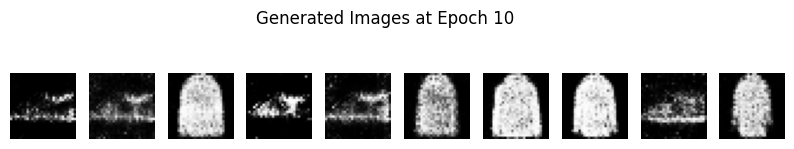

In [14]:
# Train the Modified-GAN
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for batch in range(len(x_train) // batch_size):
        idx = np.random.randint(0, len(x_train), batch_size)
        batch_images = x_train[idx]
        batch_labels = y_train[idx]

        noise = tf.random.normal([batch_size, noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = modified_gan.generator_forward(noise, batch_labels)

            real_output = modified_gan.discriminator_forward(batch_images, batch_labels)
            fake_output = modified_gan.discriminator_forward(generated_images, batch_labels)

            gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
            disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, modified_gan.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, modified_gan.discriminator.trainable_variables)

        modified_gan.generator.optimizer.apply_gradients(zip(gradients_of_generator, modified_gan.generator.trainable_variables))
        modified_gan.discriminator.optimizer.apply_gradients(zip(gradients_of_discriminator, modified_gan.discriminator.trainable_variables))

    print(f"Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}")

    # Plot generated images every 5 epochs
    if (epoch + 1) % 5 == 0:
        noise = tf.random.normal([10, noise_dim])
        labels = np.random.randint(0, num_classes, 10)
        generated_images = modified_gan.generator_forward(noise, labels)
        generated_images = (generated_images + 1) / 2.0  # Rescale to [0, 1]

        plt.figure(figsize=(10, 2))
        for i in range(10):
            plt.subplot(1, 10, i + 1)
            plt.imshow(generated_images[i, :, :, 0], cmap='gray')
            plt.axis('off')
        plt.suptitle(f"Generated Images at Epoch {epoch + 1}")
        plt.show()

In [18]:
modified_fid_score = evaluate(modified_gan.generator, x_test, y_test, noise_dim)
print("FID Score(Modified)", modified_fid_score)

FID Score(Modified) 86.01280042257433


In [19]:
print("FID Score", fid_score)
print("FID Score(Modified)", modified_fid_score)

FID Score 83.08958479687834
FID Score(Modified) 86.01280042257433
